# Step 4: Kawempe Grid-Based Risk Features and ML Exploration

This notebook creates a uniform grid over Kawempe, computes per-cell urban risk indicators (NDVI, buildings, services, roads), and performs basic ML clustering.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from sklearn.preprocessing import StandardScaler

# Combine Features

At this stage, all spatial features — including NDVI, infrastructure, and population — have been extracted and aligned to the grid. The data is cleaned and preprocessed, so we are now ready to design and compute the **Urban Vulnerability Score** for each grid cell based on these inputs.


In [4]:
# Load urban grid
urban_grid = gpd.read_file("../data/processed/urban_grid.geojson")

In [5]:
# Load raw OSM data
buildings = gpd.read_file("../data/raw/kawempe_buildings.geojson")
roads = gpd.read_file("../data/raw/kawempe_roads.geojson")
services = gpd.read_file("../data/raw/kawempe_services.geojson")

# Reproject all to match the NDVI grid CRS
buildings = buildings.to_crs(urban_grid.crs)
roads = roads.to_crs(urban_grid.crs)
services = services.to_crs(urban_grid.crs)

In [6]:
# Load ndvi grid
ndvi_grid = gpd.read_file("../data/processed/ndvi_grid.geojson")

In [7]:
# Load population grid
pop_grid = gpd.read_file("../data/processed/kawempe_grid_with_population.geojson")

In [8]:
# Building count
bldg_join = gpd.sjoin(buildings, urban_grid, predicate='within')
bldg_count = bldg_join.groupby(bldg_join.index_right).size()
urban_grid['building_count'] = urban_grid.index.map(bldg_count).fillna(0)

# Service count
svc_join = gpd.sjoin(services, urban_grid, predicate='within')
svc_count = svc_join.groupby(svc_join.index_right).size()
urban_grid['service_count'] = urban_grid.index.map(svc_count).fillna(0)

# Road length
roads_proj = roads.to_crs('EPSG:32636')
roads_proj['length_km'] = roads_proj.length / 1000
grid_proj = urban_grid.to_crs('EPSG:32636')
road_join = gpd.sjoin(roads_proj, grid_proj, predicate='within')
road_length = road_join.groupby(road_join.index_right)['length_km'].sum()
urban_grid['road_km'] = urban_grid.index.map(road_length).fillna(0)

# NDVI
urban_grid = gpd.sjoin(urban_grid, ndvi_grid[["geometry", "inv_ndvi"]],predicate="intersects", how="left")
urban_grid = urban_grid.drop(columns=[col for col in urban_grid.columns if col.startswith("index_")])
urban_grid["inv_ndvi"] = urban_grid["inv_ndvi"].fillna(0)

# Population
urban_grid = gpd.sjoin(urban_grid, pop_grid[["geometry", "pop_est"]], predicate="intersects", how="left")
urban_grid = urban_grid.drop(columns=[col for col in urban_grid.columns if col.startswith("index_")])
urban_grid["pop_est"] = urban_grid["pop_est"].fillna(0).astype(int)

# Final cleanup to remove duplicates if any
urban_grid = urban_grid.drop_duplicates(subset="geometry").reset_index(drop=True)


## Mask Low Activity Cells (if needed)

In [7]:
# mask = (
#     (urban_grid["building_count"] < 500) &
#     (urban_grid["service_count"] < 10) &
#     (urban_grid["road_km"] < 10)
# )

# # Define small scaling weights
# w_b = 2      # each building = ~2 people
# w_s = 5      # each service = ~5 people
# w_r = 10     # each km of road = ~10 people

# # Assign small non-zero estimated population using weighted logic
# urban_grid.loc[mask, "pop_est"] = (
#     w_b * urban_grid["building_count"] +
#     w_s * urban_grid["service_count"] +
#     w_r * urban_grid["road_km"]
# )[mask].astype(int)


## Normalize Features

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Select and scale relevant features
features_to_scale = ['inv_ndvi', 'building_count', 'service_count', 'road_km', 'pop_est']

scaler = MinMaxScaler()
urban_grid[[f"{col}_scaled" for col in features_to_scale]] = scaler.fit_transform(
    urban_grid[features_to_scale]
)


In [17]:
# check scaled data
urban_grid[['inv_ndvi_scaled', 
            'building_count_scaled', 
            'service_count_scaled', 
            'road_km_scaled', 
            'pop_est_scaled']].describe()


,inv_ndvi_scaled,building_count_scaled,service_count_scaled,road_km_scaled,pop_est_scaled
count,247.0,247.000000,247.000000,247.000000,247.000000
mean,0.0,0.189084,0.165685,0.230618,0.445688
std,0.0,0.289532,0.296790,0.310402,0.254274
min,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.226779
50%,0.0,0.009327,0.000000,0.014102,0.436293
75%,0.0,0.336091,0.172414,0.507971,0.646429
max,0.0,1.000000,1.000000,1.000000,1.000000


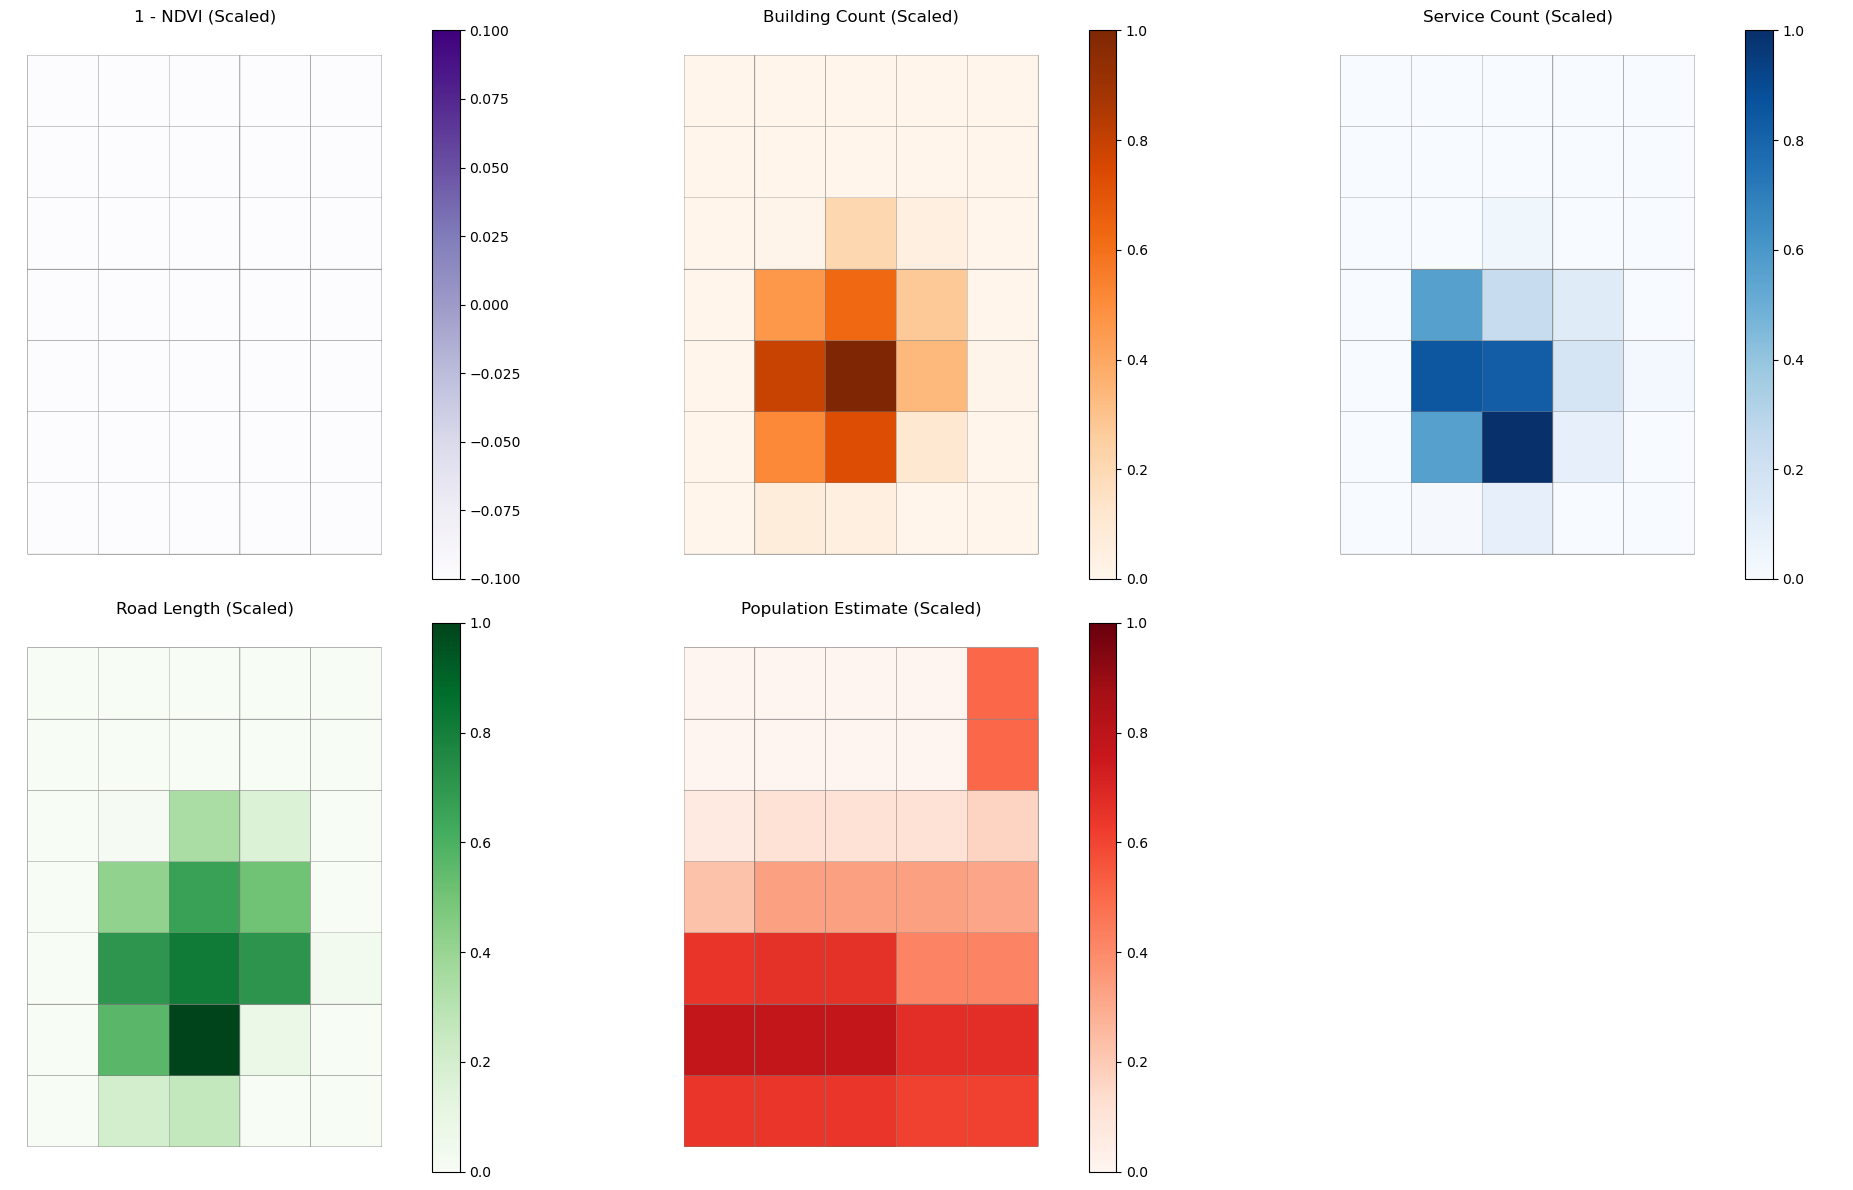

<Figure size 640x480 with 0 Axes>

In [18]:
# Plot features

scaled_cols = [f"{col}_scaled" for col in features_to_scale]

fig, axs = plt.subplots(2, 3, figsize=(20, 12))

titles = [
    "1 - NDVI (Scaled)",
    "Building Count (Scaled)",
    "Service Count (Scaled)",
    "Road Length (Scaled)",
    "Population Estimate (Scaled)"
]

cmaps = ["Purples", "Oranges", "Blues", "Greens", "Reds"]

for i, col in enumerate(scaled_cols):
    row = i // 3
    col_index = i % 3
    urban_grid.plot(
        column=col,
        cmap=cmaps[i],
        legend=True,
        edgecolor="gray",
        linewidth=0.2,
        ax=axs[row, col_index]
    )
    axs[row, col_index].set_title(titles[i])
    axs[row, col_index].axis("off")

# Hide unused sixth subplot
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()

plt.savefig("../visualizations/features_map.png", dpi=300, bbox_inches='tight')


# Vulnerability Scores

## Vulnerability Score 1: “Hidden Vulnerability” (Low Infra + High Pop)

This score highlights pockets with high population but low infrastructure access, which may be overlooked in traditional risk models.

Components:
- pop_est_scaled → High is risky
- building_count_scaled, service_count_scaled, road_km_scaled → Low is risky

In [19]:
urban_grid['vuln_score_hidden'] = (
    urban_grid['pop_est_scaled'] *
    (1 - urban_grid['building_count_scaled']) *
    (1 - urban_grid['service_count_scaled']) *
    (1 - urban_grid['road_km_scaled'])
)


## Vulnerability Score 2: “Rescue Priority” (High Pop + High Infra)

This score is useful in disaster scenarios (e.g., earthquakes), where areas with both high population and dense infrastructure may need urgent response due to potential for large-scale impact.

Components:
- pop_est_scaled and all infra → High is risky


In [20]:
urban_grid['vuln_score_rescue'] = (
    0.4 * urban_grid['pop_est_scaled'] +
    0.2 * urban_grid['building_count_scaled'] +
    0.2 * urban_grid['service_count_scaled'] +
    0.2 * urban_grid['road_km_scaled']
)

## Visualize Scores

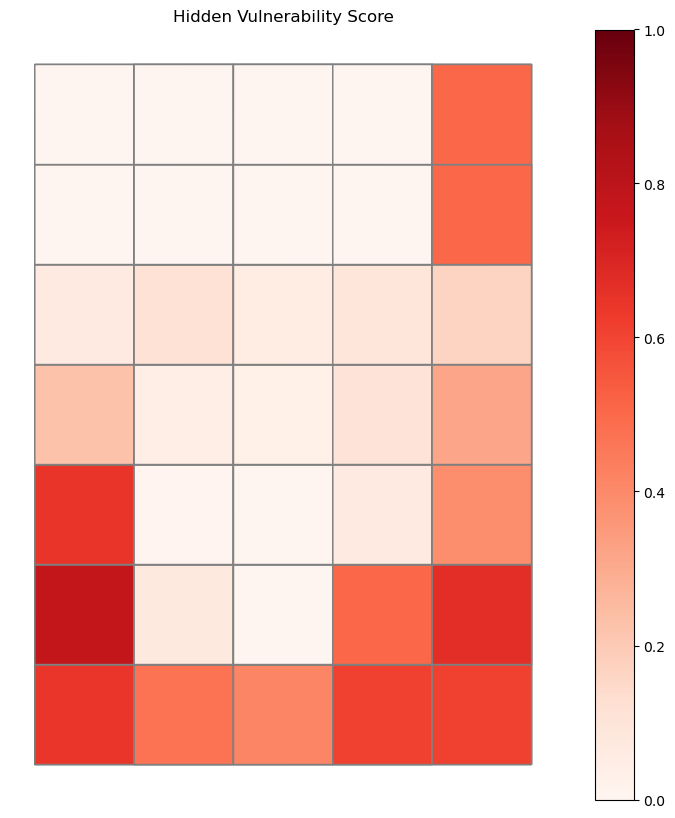

<Figure size 640x480 with 0 Axes>

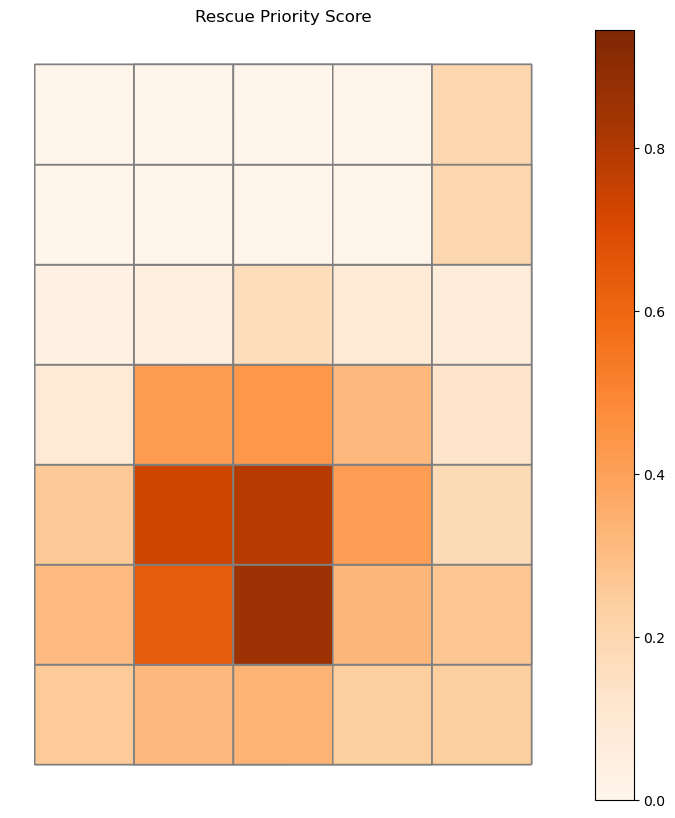

<Figure size 640x480 with 0 Axes>

In [21]:
urban_grid.plot(column='vuln_score_hidden', cmap='Reds', legend=True, figsize=(10, 10), edgecolor='gray')
plt.title("Hidden Vulnerability Score")
plt.axis('off')
plt.show()

plt.savefig("../visualizations/vuln_score_hidden_map.png", dpi=300, bbox_inches='tight')

urban_grid.plot(column='vuln_score_rescue', cmap='Oranges', legend=True, figsize=(10, 10), edgecolor='gray')
plt.title("Rescue Priority Score")
plt.axis('off')
plt.show()

plt.savefig("../visualizations/vuln_score_rescue_map.png", dpi=300, bbox_inches='tight')


# Vulnerability Classification

In this section, we compute multiple vulnerability scores based on scaled features such as population density, infrastructure access, and vegetation cover. These scores help identify:

- **Hidden Vulnerability**: Areas with high population and poor infrastructure
- **Rescue Priority**: Densely populated zones with heavy infrastructure, at risk during disasters

The resulting metrics guide targeted interventions, planning, and resource allocation.


In [22]:
# Define vulnerability score columns to classify
score_cols = ['vuln_score_hidden', 'vuln_score_rescue']

# Loop through each score and create a classified level column
for col in score_cols:
    # Apply qcut without labels to determine how many bins are valid
    bins = pd.qcut(urban_grid[col], q=4, duplicates='drop')
    n_bins = len(bins.cat.categories)
    
    # Map labels (adjust if fewer bins due to tied values)
    labels_map = ['Low', 'Medium', 'High', 'Very High'][:n_bins]
    
    # Create new column with classification labels
    level_col = f"{col}_level"
    urban_grid[level_col] = pd.qcut(
        urban_grid[col],
        q=4,
        labels=labels_map,
        duplicates='drop'
    )


## Visualize Vulnerability Levels

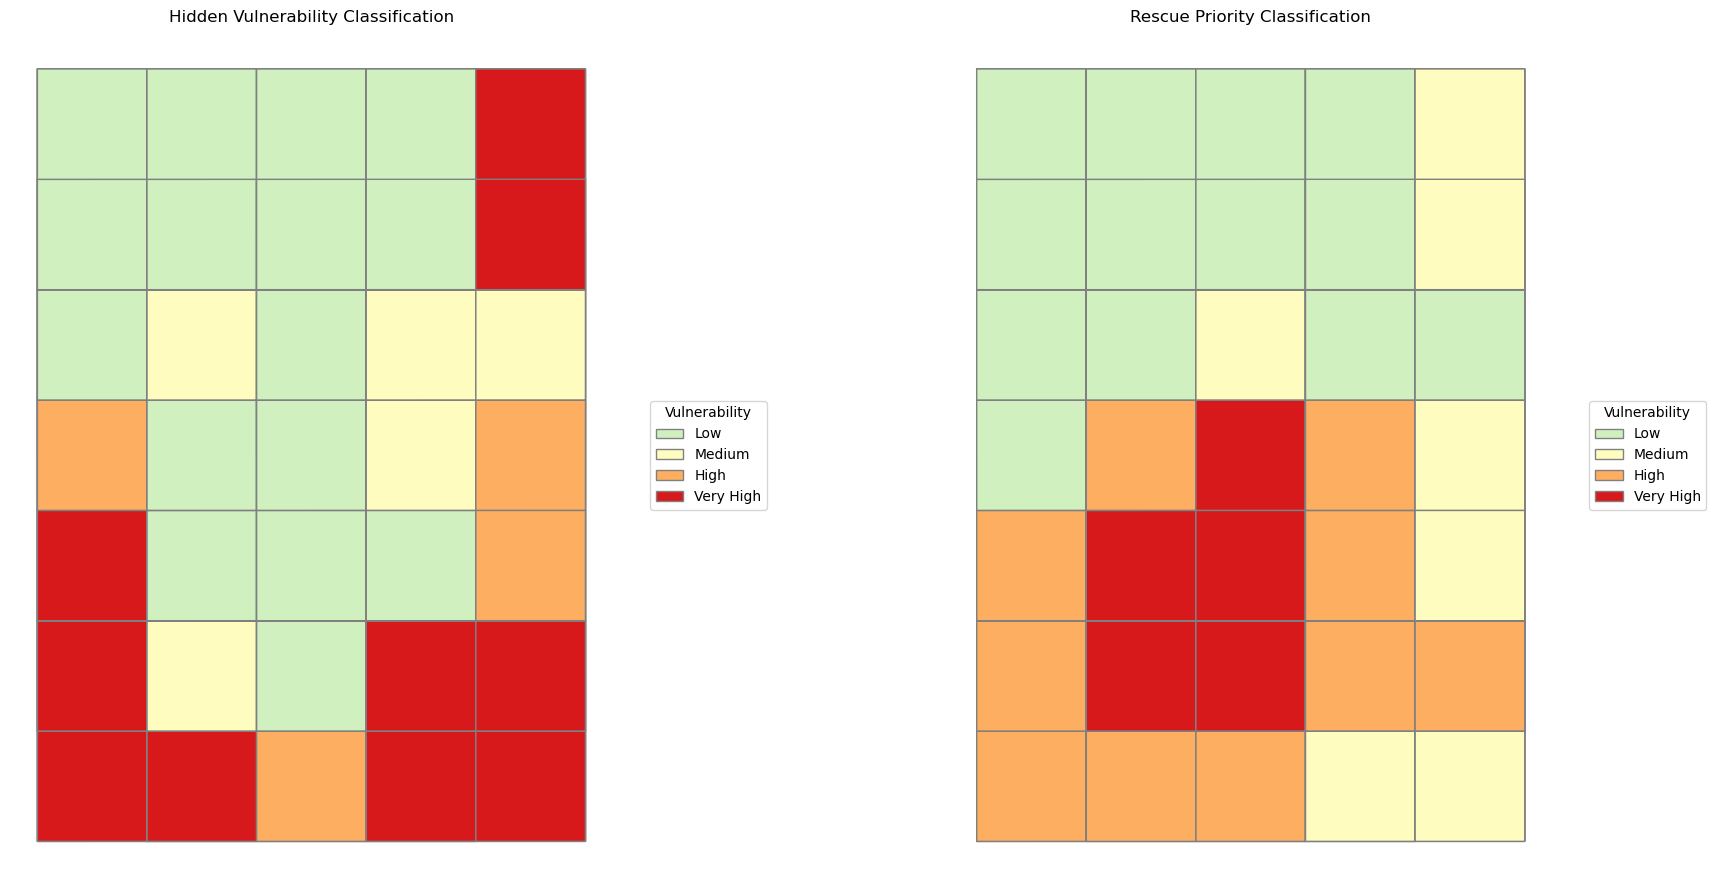

<Figure size 640x480 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Define levels and colors
labels_ordered = ['Low', 'Medium', 'High', 'Very High']
color_map = {
    'Low': '#d0f0c0',
    'Medium': '#fefcbf',
    'High': '#fdae61',
    'Very High': '#d7191c'
}
legend_elements = [Patch(facecolor=color_map[label], edgecolor='gray', label=label) for label in labels_ordered]

# Create plots with extra space on the right
fig, axes = plt.subplots(1, 2, figsize=(20, 9))  # wider to accommodate legends

# Hidden Vulnerability
urban_grid.plot(
    ax=axes[0],
    edgecolor='gray',
    color=urban_grid['vuln_score_hidden_level'].map(color_map)
)

axes[0].set_title("Hidden Vulnerability Classification")
axes[0].axis('off')
axes[0].legend(
    handles=legend_elements,
    title="Vulnerability",
    loc='center left',
    bbox_to_anchor=(1.05, 0.5)
)

# Rescue Priority
urban_grid.plot(
    ax=axes[1],
    edgecolor='gray',
    color=urban_grid['vuln_score_rescue_level'].map(color_map)
)

axes[1].set_title("Rescue Priority Classification")
axes[1].axis('off')
axes[1].legend(
    handles=legend_elements,
    title="Vulnerability",
    loc='center left',
    bbox_to_anchor=(1.05, 0.5)
)

plt.tight_layout()
plt.show()

plt.savefig("../visualizations/vulnerability_classification_map.png", dpi=300, bbox_inches='tight')